# 4. Übungsblatt

by 
- Javier Carrasco Melo
- Fariza Sabit

# Aufgabe 4.3
Zunächst definieren wir die Pfade zum Lesen der Roddaten und Schreiben die Feature-Matrix. Falls der Ordner "Feature_Matrix" noch nicht in Ihrem aktuellen Verzeichnis existiert, wird der Ordner angelegt.

In [ ]:
import os
reduced_train_dataset_path = "/home/share/AR/AR_Train.dat"
reduced_test_dataset_path = "/home/share/AR/AR_Test.dat"

feature_matrix_dir = os.getcwd() + os.sep + "Feature_Matrix" + os.sep
train_feature_matrix_path = feature_matrix_dir + "Train_Feature_Matrix.dat"
test_feature_matrix_path = feature_matrix_dir + "Test_Feature_Matrix.dat"

# Wenn der Ordner Feature_Matrix noch nicht existiert legen wir ihn im aktuellen Verzeichnis an.
if not os.path.isdir(feature_matrix_dir):
    os.makedirs(feature_matrix_dir)

Als nächstes definieren wir ein Dictionary, das von der Class-ID zum entsprechenden Namen abbildet.

In [ ]:
class_map_to_string = {0.0: "Null",
                       1.0: "Stand",
                       2.0: "Walk",
                       4.0: "Sit",
                       5.0: "Lie",
                      }

In der folgenden Funktion wird die Feature-Matrix berechnet

In [ ]:
import sys
import numpy as np

def create_feature_matrix():
    reduced_train_dataset = None
    reduced_test_dataset = None

    train_feature_matrix = None
    test_feature_matrix = None

    phases = ["train", "test"]
    for phase in phases:

        if phase == "train":
            all_data = np.loadtxt(reduced_train_dataset_path)
        else:
            all_data = np.loadtxt(reduced_test_dataset_path)


        timestamps = all_data[:, 0]
        labels = all_data[:, -1]

        sensor_data = all_data[:, [[1,2,3]]].astype(float)
        
        reverse_time = list(timestamps).copy()
        reverse_time.reverse()

        mean_sampling_rate = np.array([reverse_time[i] - reverse_time[i + 1] for i in range(len(reverse_time) - 1)]).mean()
        num_samples_per_sec = round(1000.0 / float(mean_sampling_rate), 2)

        window_size_in_sec = 3.0
        num_elements_in_window = int(window_size_in_sec * num_samples_per_sec)
        window_shift_size = int(float(num_elements_in_window) / 4.0)
        
        """
        Jede Zeile der Feature-Matrix correspondiert zu einem Fenster F_i. Die letzte Spalte einer Zeile i in der 
        Feature-Matrix enthält das Label L_i, alle anderen Spalten enthalten die Feature-Werte des entsprechenden
        Fensters.
        """
        temp_feature_matrix = []

        start = 0
        end = num_elements_in_window

        while end < len(labels):
            print_string = "Aktuelle Endposition des Fensters: " + str(end) + "/" + str(len(labels))
            sys.stdout.write('\r'+print_string)
            sys.stdout.flush()
            next_labels = list(labels[start:end])
            
            """
            class_count_dict ist ein Dictionary, wobei die Keys die Klassen-IDs speichern und die Values,
            die Häufigkeit einer Klasse innerhalb des aktuellen Fensters angibt.
            """
            class_count_dict = Counter(next_labels)


            num_classes = len(class_count_dict.values())

            """
            argmax_cls ist der Key in class_count_dict, der den maximalen Wert hat. Folglich enthält: 
                class_count_dict[argmax_cls]
            die Anzahl der am meisten vorkommenden Labels (Majority Vote).
            """
            argmax_cls = max(Counter(next_labels), key=Counter(next_labels).get)

            next_window = sensor_data[start:end, :]

            """
            Statt nur nach dem majority vote zu gehen verwenden wir noch eine weitere Bedingung. Die Anzahl der Labels innerhalb
            eines Fensters muss mindestens 75% aller Labels des aktuellen Fensters entsprechen. Wenn das nicht zutrifft, oder
            es einen Fehler im Sensor gab (NaN), dann verwerfen wir das aktuelle Fenster und berechnen auch keine Feature für
            dieses Fenster.
            """
            if float(class_count_dict[argmax_cls]) / float(num_elements_in_window) > 0.75 and not np.isnan(np.sum(next_window)):
                temp_feature_matrix.append(compute_features(next_window, mean_sampling_rate) + [argmax_cls])

            start = start + window_shift_size
            end = end + window_shift_size

        if len(temp_feature_matrix) > 0:
            temp_feature_matrix = np.array(temp_feature_matrix).reshape(len(temp_feature_matrix), len(temp_feature_matrix[0]))

            if phase == "train":
                if train_feature_matrix is None:
                    train_feature_matrix = temp_feature_matrix.copy()
                else:
                    train_feature_matrix = np.vstack((train_feature_matrix, temp_feature_matrix))
            else:
                if test_feature_matrix is None:
                    test_feature_matrix = temp_feature_matrix.copy()
                else:
                    test_feature_matrix = np.vstack((test_feature_matrix, temp_feature_matrix))

    np.savetxt(train_feature_matrix_path, train_feature_matrix, '%1.9f')
    np.savetxt(test_feature_matrix_path, test_feature_matrix, '%1.9f')

    return train_feature_matrix, test_feature_matrix



## Berechne Feature (ToDo siehe 8. Woche)
Die folgende Funktion berechnet bisher die zwei sehr einfachen Feature min und max. Überlegen Sie sich weitere Feature (z.B. Durchschnitt, Standardabweichung etc., insgesamt mindestens fünf) und implementieren Sie diese.

In [ ]:
def compute_features(window_values, mean_sampling_rate):
    features = []
    
    for i in range(len(window_values[0])):
        cur_sensor_data = window_values[:,i]

        x_values = [elem[0] for elem in cur_sensor_data]
        y_values = [elem[1] for elem in cur_sensor_data]
        z_values = [elem[2] for elem in cur_sensor_data]
        magnitudes = [np.sqrt(elem[0] ** 2 + elem[1] ** 2 + elem[2] ** 2) for elem in cur_sensor_data]

        num_samples_in_window = float(len(magnitudes))

        for liste in [x_values, y_values, z_values, magnitudes]:
            # Definiere hier einige Feature
            min_value = min(liste)
            max_value = max(liste)
            sd = np.std(liste)
            mean = np.mean(liste)
            median = np.median(liste)
            iqr = np.subtract(*np.percentile(liste, [75, 25]))

            features.extend([min_value, max_value, sd, mean, median, iqr])
           

            # Füge die neu definierten Feature zu dieser Liste hinzu:
            features.extend([min_value, max_value])  # ToDo
            

    return features

## Normalisieren (ToDo siehe 9. Woche)
Als nächstes sollen Sie die Daten normalisieren. Sie können entweder die Klassen StandardScaler oder MinMaxScaler von sklearn verwenden, oder die Normalisierung selbst implemnetieren. Achten Sie beim Normalisieren darauf, dass sie die entsprechenden Konstanten (beim StandardScaler z.B. Mittelwert und Standardabweichung) nur auf den Trainingsdaten berechnen und die gleichen Konstanten beim Normalisieren des Testdatensatzes verwenden. Wieso machen wir das so? Bei den oben genannten Klassen, gibt es die Methode fit_transform(), diese berechnet die Konstanten und die Methode transform(), normalisiert die Daten gemäß der zu vor gespeicherten Konstanten.

In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_data(x_train_unnormalized, x_test_unnormalized):    
    scaler = StandardScaler()
    scaler.fit(x_train_unnormalized)
    x_train_normalized = scaler.transform(x_train_unnormalized)
    x_test_normalized = scaler.transform(x_test_unnormalized)
    
    return x_train_normalized, x_test_normalized

## Klassifizieren (ToDo)
Vervollständigen Sie die Methode classify so, dass die folgenden Klassifizierer verwendet werden können:
- k-NN
- Decision Tree
- Support Vector Machine (in sklearn heißt die Regression Version SVM und die Klassifizierer Version SVC)
- Multilayer-Perzeptron

und das MLP einen $F_1$-Score von $80\%$ oder besser auf dem Testdatensatz erreicht. Wie üblich soll der Klassifizierer mit dem Trainingssatz train_data trainiert und anschließend auf dem Testdatensatz test_data getestet werden. Nach dem Test soll eine Evaluation des Testergebnisses durchgeführt werden. Dabei soll der $F_1-$Score und die Confusion-Matrix berechnet werden. Abschließend soll die Confusion Matrix als Heatmap geplottet werden (vergleiche 9. Woche).

In [ ]:
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix


def classify(train_data, test_data, cls_name=None):
    x_train, y_train = train_data[:, :-1], train_data[:, -1]
    x_test, y_test = test_data[:, :-1], test_data[:, -1]

    # DO NOT CHANGE -->
    # Entferne alle Zeilen der Feature-Matrix mit Klassen-ID 0 (Null-Class, siehe Zusatzmaterial)
    all_null_indices_train = [i for i, lbl in enumerate(y_train) if lbl == 0]
    all_null_indices_test = [i for i, lbl in enumerate(y_test) if lbl == 0]
    x_train = [elem for i, elem in enumerate(x_train) if not i in all_null_indices_train]
    y_train = [elem for i, elem in enumerate(y_train) if not i in all_null_indices_train]
    x_test = [elem for i, elem in enumerate(x_test) if not i in all_null_indices_test]
    y_test = [elem for i, elem in enumerate(y_test) if not i in all_null_indices_test]
    # <--

    # Normalisiere x_train und x_test
    x_train_normalized, x_test_normalized = normalize_data(x_train, x_test)
    
    # Implementiere die Klassifizierung
    # ToDo:
    
    if cls_name:
        cls_names = [cls_name]
    else: 
        cls_names = ["Decision Tree", "Support Vector Machine", "GaussianNB", "BernoulliNB", 
                     "RandomForestClassifier", "AdaBoostClassifier", "Multilayer-Perzeptron", "k-NN"]
    
    for cls_name in cls_names:
        if cls_name == "k-NN":
            cls = KNeighborsClassifier()   # n_neighbors=5
        elif cls_name == "Decision Tree":
            cls = DecisionTreeClassifier()
        elif cls_name == "Support Vector Machine":
            cls = SVC()
        elif cls_name == "GaussianNB":
            cls = GaussianNB()
        elif cls_name == "BernoulliNB":
            cls = BernoulliNB()
        elif cls_name == "RandomForestClassifier":
            cls = RandomForestClassifier()
        elif cls_name == "AdaBoostClassifier":
            cls = AdaBoostClassifier()
        elif cls_name == "Multilayer-Perzeptron":
            cls = MLPClassifier(hidden_layer_sizes=111, max_iter=200)
        
        cls.fit(x_train, y_train)
        y_pred = cls.predict(x_test)
        f1 = round(f1_score(y_test, y_pred, average="micro"), 3)
        print(f"{cls_name}'s F_1: {f1}")
    
    return cls, x_test, y_test

Falls die Feature Matrizen "Train_Feature_Matrix.dat" und "Test_Feature_Matrix.dat" schon existieren, wird direkt die classify Methode ausgeführt, andernfalls werden vorher noch die Feature-Matrizen berechnet. Achten Sie also darauf in der Methode compute_features die Feautureberechnung anzupassen.

In [ ]:
if not (os.path.isfile(train_feature_matrix_path) and os.path.isfile(test_feature_matrix_path)):
    train_feature_matrix, test_feature_matrix = create_feature_matrix()
else:
    train_feature_matrix =  np.loadtxt(train_feature_matrix_path)
    test_feature_matrix = np.loadtxt(test_feature_matrix_path)

In [ ]:
# protip: if you run it multiple times, you'll eventually get an MLP with F_1 > 0.8
cls, x_test, y_test = classify(train_feature_matrix, test_feature_matrix) #, cls_name="k-NN")

Decision Tree's F_1: 0.801
Support Vector Machine's F_1: 0.755
GaussianNB's F_1: 0.814
BernoulliNB's F_1: 0.708
RandomForestClassifier's F_1: 0.805
AdaBoostClassifier's F_1: 0.78
Multilayer-Perzeptron's F_1: 0.817
k-NN's F_1: 0.822


Unless otherwise is stated, the confusion matrix (following blocks) is based on the model trained using k-NN.

In [ ]:
# this matrix shows in the diagonal the correctly identified classes (e.g., stehen, sitzen, liegen...)
conf_matrix = confusion_matrix(y_test, cls.predict(x_test))
conf_matrix

array([[287,  11,  37,   0],
       [ 44,  91,   0,   0],
       [ 55,   0, 247,   0],
       [  0,   0,   0,  52]])

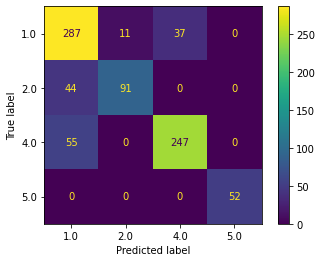

In [ ]:
plot_confusion_matrix(cls, x_test, y_test)

# Aufgabe 4.4

Ein binärer Klassifizierer $K_1$ liefert auf den Validierungsdaten die nachfolgende Confusion Matrix.

In [ ]:
# we will asume that Klasse A will represent a positive outcome, and that Klasse B will represent a negative outcomme
TP = 100
TN = 5
FP = 8
FN = 2

Beantworten Sie die folgenden Fragen:

1. **Wie viele Daten gehören zur Klasse A und wie viele zur Klasse B?**

*Klasse A*: 102 elements; *Klasse B*: 13 elements

2. **Berechnen Sie Precision, Recall, Accuracy und den F1-Score**

In [ ]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = 2 * TP / (2 * TP + FP + FN)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F_1: {f1}")

Precision: 0.9259259259259259
Recall: 0.9803921568627451
Accuracy: 0.9130434782608695
F_1: 0.9523809523809523


3. **Ist eine dieser Messungen ausreichend um die Qualität des Klassifizierers zu beschreiben? Wenn ja, welche Messung beschreibt die Qualität des Klassifizierers am besten. Falls nicht was ist das Problem?**

$F_1$ is better than the Accuracy when we have imbalanced data distribution, like in this exercise. Klasse A has much more elements than Klasse B, about 90% to 10%.

4. **Angenommen wir haben einen zweiten Klassifizierer K2 der über eine Gleichverteilung zufällig entscheidet ob ein Sample zur Klasse A oder B gehört. Welche Accuracy hat K2?**

In [ ]:
# we will use new values to calculate our accuracy
TP = 51
TN = 6
FP = 7
FN = 51

accuracy_2 = (TP + TN) / (TP + TN + FP + FN)
f1_2 = 2 * TP / (2 * TP + FP + FN)

print(f"Accuracy 2: {accuracy_2}; accuracy 1: {accuracy}")
print(f"F_1 2: {f1_2}; F_1 1: {f1}")

Accuracy 2: 0.4956521739130435; accuracy 1: 0.9130434782608695
F_1 2: 0.6375; F_1 1: 0.9523809523809523


5. **Welcher Klassifizierer ist für die korrekte Klassifizierung von Samples aus der Klasse B besser, K1 oder K2?**

K2 will do a slightly better job at correctly classifying (i.e., recognizing true negatives) samples from Klasse B: 6 or 7 vs 5 (K1).

6. **Was würden Sie empfehlen, um K1 zu verbessern?**

During the data collection, if it is possible, we would recommend to make the samples more balanced in terms of Klasse A and Klasse B, getting more data from Klasse A.

# Aufgabe 4.5

Erklären Sie die folgenden Klassifizierer in Ihren eigenen Worten (je ca 5-10 Sätze) mit Abbildungen und ggf. Berechnungsformeln:

## (a) k-Nearest Neighbor

KNN is a simple and powerful tool used for both classification and regression in supervised learning. It can be a benchmark for other more complicated neural-network-based classifiers because
*  KNN is a *non-parametric*, meaning that the algorithm is free to learn any functional form from the training data. Thus the probabilty of mismodeling the underlying function is low; 

* KNN is instance-based making the algorithm to adapt to new data easily.
 
However, there are main disadvantages of instance-based learning algorithm:

* Fast training, slow testing (Each query calculates the local model from scratch);
* Memory inefficient;
* A risk of overfitting due to remembering all training instances.

**Idea:** In the 'training' phase the algorithm stores the feature vectors and labels of the training dataset. In the testing phase, the algorithm finds the k nearest neighbours by comparing the Euclidean (but not necessary) distance:

$d(x_i, x)= \sqrt{(x_1-x)^2+(x_2-x)^2+...+(x_n-x)^2}$

Then looks up labels of those k closest neighbors and
assigns majority vote label for the input $x$:
$P(y=j | X=x ) = \frac{1}{K}\sum I(y=j)$

<img src="https://kevinzakka.github.io/assets/knn/20nn.png" width="400" height="400" />


## (b) Decision Tree
 
Decision Tree algorithm is an intuitive, non-parametric supervised learning technique used to solve both classification and regression problems. Here the algorithm learns decision rules by continuiosly splitting the data according to a certain parameter.  

**Idea:** Classify an input by asking a series of carefully crafted questions about the attributes of the dataset until we come up with the class label. The series of questions and their possible answers will be organized in the form of a hierarchical decision tree consisting of nodes (input), edges (attributes) and lead nodes (class label). 

One of the algorithms used in Decision Trees is Classification And Regression Tree (CART). CART uses Gini Impurity score to optimally split the dataset into a decision tree (the lower the better) [[1](https://books.google.de/books/about/Hands_On_Machine_Learning_with_Scikit_Le.html?id=HnetDwAAQBAJ&printsec=frontcover&source=kp_read_button&redir_esc=y#v=onepage&q&f=false)] :

$$G_i = 1 - \sum ^n_{k=1} p_{i,k}^2 $$ 
where $p_{i,k}$ is the estimated probaility of class k in the ith node.

*Remark:* Instead of Gini impurity one can also use Entropy impurity measure.

Some drawbacks:  
- Unstable, i.e. a small change in the data can lead to a large change in the structure of the tree;
- Relatively expensive as the comptational complexity and time has taken are more.

<img src="https://i1.wp.com/dataaspirant.com/wp-content/uploads/2017/01/B03905_05_01-compressor.png?resize=768%2C424&ssl=1" width = 500 heght=400>


## (c) Support Vector Machine (SVM)

SVM is a supervised learning model, particularly well suited for classification of complex but small- or medium-sized datasets [[3](https://books.google.de/books/about/Hands_On_Machine_Learning_with_Scikit_Le.html?id=HnetDwAAQBAJ&printsec=frontcover&source=kp_read_button&redir_esc=y#v=onepage&q&f=false)].

**Idea:** The algorithm finds the boundary with maximum margin between classes. The equation for a descision hyperplane $\mathbb{R}^D$ is $$w^Tx - \beta=0$$
Scale $w$ such that points $x_0$ closest to hyperplane $w$ have distance 1:
$$\alpha w^Tx - \beta=0$$
$$\alpha = \frac{|w^Tx - \beta|}{\parallel w \parallel _2 }$$
where $\alpha w$ is called canonical hyperplane. Notice that for canonical hyperplanes that correctly classify all data $$y_i ( w^Tx_i - \beta) \geq 1$$

An optimization problem then for SVMs is to find the normal vector $w$ to the canonical hyperplane with the smallest norm [[2](https://link.springer.com/article/10.1007/BF00994018)]:
$$ \min _w \frac{1}{2} \parallel w \parallel _2 $$
$$\text{subject to  } y_i ( w^Tx_i - \beta) \geq 1$$

The data points (*vectors*) $x$ closest to the margin define (*support*) the hyperplane $w$ - hence **support-vectors**.

For non-separable data sets (not linear) we can relax the original SVM objective to allow for an error of $\varepsilon_i$ for the $i$th data point by introducing slack variables: 
$$y_i ( w^Tx_i - \beta) \geq 1 - \varepsilon _i$$

Non-Linear SVMs use the so called "Kernel trick", which allow them to project input data into a higher-dimension space as depicted in the figure below.

<img src="https://www.researchgate.net/profile/Muhammad_Awais_Bin_Altaf/publication/272520997/figure/fig2/AS:601593388998663@1520442449352/Motivation-behind-non-linear-SVM-classifier.png" weight=400  height=400>




## (d) Multilayer Perceptron (MLP)

MLP is a type of feed-forward artificial neural networks, made of multiple fully-connected perceptron layers. Here is an example of a very basic MLP:

<img src="https://www.tutorialspoint.com/tensorflow/images/multi_layer_perceptron.jpg" height=300 weight=300 >

An MLP consists of one input layer, one or more hidden layers and one output layer. Each layer is made up by nodes that are connected to all nodes in the previous (except input) and the following layer (except output), i.e., it is fully connected.

Each node (or neuron) calculates the weighted sum of all the connections from the previous layer and applies the value to an activation function, usually a sigmoid function. This process is done to each layer in one direction (this makes it feed-forward), from the input to the output layer, passing through the hidden layer.

The training of the model is done through backpropagation. The output is compared to the expected result, getting the error. Then the algorithm calculates the contribution of each neuron to this error, going one layer at a time in reverse from the output to the input layer. This way, the algorithm finds the gradients that will be used to slightly tweak the weights of this network to reduce the error.

Source: [The Nature of Code](https://natureofcode.com/book/chapter-10-neural-networks/)

Some disadvantages of MLP:

- fully connected layers $\to$ no convolution layers $\to$ too many parameters $\to$ redunancy & inefficiency 
- vanishing gradient problem due to exponentially decreasing/increasing errors 
